# Homework 4: SVM


This assignment is due on Moodle by **11:59pm on Monday March 31**. 
Your solutions to theoretical questions should be done in Markdown/MathJax directly below the associated question.
Your solutions to computational questions should include any specified Python code and results 
as well as written commentary on your conclusions.
Remember that you are encouraged to discuss the problems with your instructors and classmates, 
but **you must write all code and solutions on your own**. For a refresher on the course **Collaboration Policy** click [here](https://github.com/akkikiki/CSCI-4622-Machine-Learning-sp21/blob/main/info/syllabus.md#collaboration-policy).

**NOTES**: 

- Do **NOT** load or use any Python packages that are not available in Anaconda (Version: 2019.07) with Python 3.7. 
- Some problems with code may be autograded.  If we provide a function API **do not** change it.  If we do not provide a function API then you're free to structure your code however you like. 
- Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. 
- In this homework you will explore the primal and dual representations of support vector machines, as well as the performance of various kernels while classifying sentiments. Install the following packages: `nltk` (Version: 3.5), `scikit-learn` (Version: 0.23.2)


**Please put your name and cuidentity username.**

**Name**: Kai Hueske-VanCeylon

**Identity Key**: kahu1945

In [1]:
import math
import pickle
import gzip
import numpy as np
import pandas
import matplotlib.pylab as plt
%matplotlib inline

# Set random seed for deterministic output
np.random.seed(5622)

[40 Points] Problem 1 - Basic concepts of SVM
---

### Part 1 [10 points]
* What are the main differences between the primal and the dual representations?
* For the variables $\xi_i$, $C$ in the primal formation, what are their roles? Write out the upper/lower bounds (constraints) of these variables. What are the interpretation for these maximum/minimum values?
* For the variable $\alpha_i$, $\beta_i$ in the dual formation, what are the upper/lower bound (constraints) of them?

The primal representation only supports linear classification, and doesn't allow the use of kernels. The dual SVM representation includes a Lagrangian objective function, and allows kernels to be used to extend the SVM's applicability to non-linear classification problems.  
The variables in $\xi$ are the slack variables. They allow the SVM to have a "soft margin", allowing points to be classified as a particular cluster despite being on the wrong side of the decision boundary. $C$ determines how heavily these slack variables are weighted the objective function, which affects how the SVM is fitted. $C$ has a lower bound of 0, at which point the slack variables aren't taken into consideration at all, and the SVM becomes hard-margin.  
The slack variables $\xi$ also have a lower bound of 0. This is because data points on the correct side of the margin don't need slack variables to correct them. Data within the margin have slack variables between 0 and 1, since they're within 1 margin of the correct side, and data on the wrong side of the margin have slack variables greater than 1.

In the dual representation, $0 \leq \alpha_i \leq C$, and for the corresponding $\beta_i$, $\alpha_i + \beta_i = C$ (which naturally means $0 \leq \beta_i \leq C$ as well).

### Part 2 [20 points]

 * Given a weight vector, implement the `find_support` function that returns the indices of the support vectors.
 * Given a weight vector, implement the `find_slack` function that returns the indices of the vectors with nonzero slack.
 * Given the alpha dual vector, implement the `weight_vector` function that returns the corresponding weight vector.

In [2]:
class SVM:
    def __init__(self):
        self.kINSP = np.array([
            (1, 8, +1),
            (7, 2, -1),
            (6, -1, -1),
            (-5, 0, +1),
            (-5, 1, -1),
            (-5, 2, +1),
            (6, 3, +1),
            (6, 1, -1),
            (5, 2, -1)
        ])
        self.kSEP = np.array([
            (-2, 2, +1),    # 0 - A
            (0, 4, +1),     # 1 - B
            (2, 1, +1),     # 2 - C
            (-2, -3, -1),   # 3 - D
            (0, -1, -1),    # 4 - E
            (2, -3, -1),    # 5 - F
        ])


    def weight_vector(self, x, y, alpha):
        """
        Given a vector of alphas, compute the primal weight vector w.
        The vector w should be returned as an Numpy array.
        
        Returns:
            w (np.ndarray): The primal weight vector w.
        """
        w = np.zeros(len(x[0]))
        for i in range(len(x)):
            w += (alpha[i] * y[i] * x[i])
        return w



    def find_support(self, x, y, w, b, tolerance=0.001):
        """
        Given a set of training examples and primal weights, return the indices
        of all of the support vectors as a set.
        
        Returns:
            support (set) : set of support vector indices
        """
        support = set()
        for i in range(len(x)):
            if y[i] * (np.dot(w, x[i]) + b) <= 1 + tolerance:
                support.add(i)
        return support



    def find_slack(self, x, y, w, b):
        """
        Given a set of training examples and primal weights, return the indices
        of all examples with nonzero slack as a set.
        
        Returns:
            slack (set) : set of slack indices 
        """

        slack = set()
        for i in range(len(x)):
            if y[i] * (np.dot(w, x[i]) + b) < 1:
                slack.add(i)
        return slack

In [3]:
from tests import tests
tests.run_test_suite("prob 1", SVM)

TestWideSlack (tests.tests.TestSVM) ... ok
TestNarrowSlack (tests.tests.TestSVM) ... ok
TestSupport (tests.tests.TestSVM) ... ok
TestWeight (tests.tests.TestSVM) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.022s

OK


### Part 3 [10 points]

The goal of this problem is to correctly classify test data points, given a training data set.
For this problem, assume that we are training an SVM with a quadratic kernel, which means our kernel function is a polynomial kernel of degree 2. You are given the data set presented in the figure below. The slack penalty $C$ will determine the location of the decision boundary.

Justify the following questions in a sentence or via drawing decision boundary.
![training_data](./data/data.png)

* Where would the decision boundary be for very large values of $C$ ?
* Where you would expect the decision boundary to be if  $C = 0$ ?
* Which of the two cases above would you expect to generalize better on test data? Why?

$C$ indicates how much weight we give to the slack variables in the objective function. For a high $C$ value, less deviation from the decision boundary will be accepted, so it will be close to the green points, curving around them.  This version is more complex, and would probably tend to overfit.  
For a low $C$ value like 0, more deviation will be allowed, so the decision boundary will just try to maximize the margin, which would mean the decision boundary would be almost diagonally, sloping down to the right, and in the middle of the space between the two clusters of points. The two red points which are grouped with the green cluster would be on the wrong side of the boundary, but the slack variables would let them be classified correctly. This version is less complex, and would tend to generalize better to test data, because it doesn't constrain the categories as strongly.

[30 points] Problem 2 - The Kernel Trick
---
The kernel trick can make SVM powerful and become non-linear. In this problem we will get familiar with the kernel trick.

### Part 1 [10 points]

We will construct a support vector machine that computes the XOR function, using values of +1 and −1 (instead of 1 and 0) for both inputs and outputs, so that an example looks like ($[−1, 1], 1$) or ($[−1, −1], −1$). 
- Map the input $[x_1, x_2]$ into a space consisting of $x_1$ and $x_1x_2$. 
- Plot the four input points in this space, and the maximal margin separator. 
- Give the margin value in the markdown cell. 

Remember to indicate which points have output +1 and which -1.

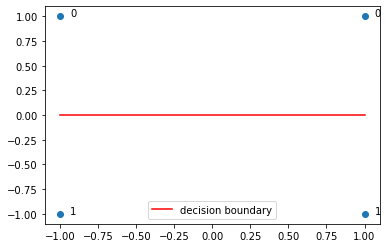

In [4]:
input_vals = np.array([[1, 1], [1, -1], [-1, 1], [-1, -1]])

# map input, define outputs
mapped = np.array([[x[0], x[0] * x[1]] for x in input_vals])
output_vals = np.array([0, 1, 1, 0])

fig, ax = plt.subplots()
ax.scatter(mapped[:, 0], mapped[:, 1])
for i, x in enumerate(input_vals):
    ax.annotate(output_vals[i], mapped[i], textcoords='offset pixels', xytext=(10, 0))
    
# boundary
ax.plot([-1, 1], [0, 0], color='red', label='decision boundary')
ax.legend()
plt.show()

Our weights vector is $\textbf{w} = [0, 1]^T$. This means our margin is $M = \frac{2}{||\textbf{w}||} = \frac{2}{\sqrt{0^2 + 1^2}} = 2$

### Part 2 [5 points]
Plot the separating line of **Part 1** back in the original Euclidean input space.

c:\users\kaih2\appdata\local\programs\python\python38\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


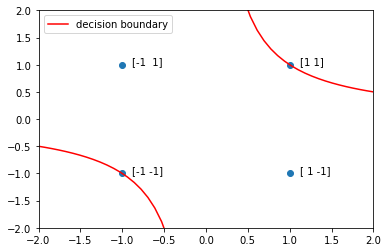

In [5]:
x1 = np.linspace(-2, -1 * (1 / 25), 25)
y1 = 1 / x1
x2 = np.linspace(1 * (1 / 25), 2, 25)
y2 = 1 / x2

fig, ax = plt.subplots()
ax.scatter(input_vals[:, 0], input_vals[:, 1])
for i in range(len(input_vals)):
    ax.annotate(input_vals[i], input_vals[i], textcoords='offset pixels', xytext=(10, 0))
    
# boundary
ax.plot(x1, y1, color='red', label='decision boundary')
ax.plot(x2, y2, color='red')
ax.set_ylim([-2, 2])
ax.set_xlim([-2, 2])
ax.legend()
plt.show()

### Part 3 [5 points]
Is the separator in **Part 1** linear? Is the one in **Part 2** linear? Explain your answer.

The separator in part 1 is linear; it's just a line in its space. The one in part 2, however, is not linear; in the original euclidean space, it has the equation $x_2 = \frac{1}{x_1}$, which is not linear.

### Part 4 [10 points]
The key point of the so-called “kernel trick” in SVMs is to learn a classifier that effectively separates the training data in a higher dimensional space without having to explicitly compute the representation $\phi(\mathbf{x})$ of every point $\mathbf{x}$ in the original input space. Instead, all the work is done through the kernel function $K(\mathbf{x}_i, \mathbf{x}_i)$, for example, we can use $K(\mathbf{x}_i, \mathbf{x}_i) = \phi(\mathbf{x}_i)\phi(\mathbf{x}_j)$.

Show how to compute the squared Euclidean distance in the projected space between any two points $\mathbf{x}_i$, $\mathbf{x}_j$ in the original space without explicitly computing the $\phi$ mapping, instead using the kernel function $K$. In other words, derive $d(\phi(\mathbf{x}_i), \phi(\mathbf{x}_j)) = (\phi(\mathbf{x}_i) - \phi(\mathbf{x}_j))\cdot(\phi(\mathbf{x}_i) - \phi(\mathbf{x}_j))$ into a form using only the kernel function.

Please remember to simplify your solution.

$d(\phi(\mathbf{x}_i), \phi(\mathbf{x}_j)) = (\phi(\mathbf{x}_i) - \phi(\mathbf{x}_j))\cdot(\phi(\mathbf{x}_i) - \phi(\mathbf{x}_j)) \\
= \phi(\mathbf{x}_i)\phi(\mathbf{x}_i) - 2\phi(\mathbf{x}_i)\phi(\mathbf{x}_j) + \phi(\mathbf{x}_j))\phi(\mathbf{x}_j)) \\
= K(\mathbf{x}_i, \mathbf{x}_i) - 2K(\mathbf{x}_i, \mathbf{x}_j) + K(\mathbf{x}_j, \mathbf{x}_j)$

[30 points] Problem 3 - SVM with `sklearn`
---

In this problem, you will get familiar with important practical functions in scikit-learn such as pipeline, grid search, and cross validation. You will experiment with these using support vector machines.

Note that grid search can take some time on your laptop, so make sure that your code is correct with a small subset of the training data and search a reasonable number of options.

* Use the Sklearn implementation of support vector machines to train a classifier to distinguish Positive and negative sentiments
* Experiment with linear, polynomial, and RBF kernels. First, perform a GridSearch over each kernel function and a small set of parameters defined over a wide range to help narrow down the search space.
* Then choose the best performing kernel from your coarse scale search and define a narrower set of parameters for random search to further optimize the hyperparameters. Comment on the experiments you ran and optimal hyperparameters you found.
Hint: http://scikit-learn.org/stable/modules/grid_search.html
* Evaluate classification performance for each model for optimal parameters by testing on a hold-out set.

Following is a dataset containing reviews and sentiments associated with it.

We will create a SVM Classifier to predict positive or negative sentiments.

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
reviews  = pd.read_csv('./data/reviews.csv')
train, test = train_test_split(reviews, test_size=0.2, random_state=5622)
X_train = train['reviews']
X_test = test['reviews']
y_train = train['sentiment']
y_test = test['sentiment']

# Print some data info
print(f'[Sizes] train: {len(X_train)}, test: {len(X_test)}')
print(f'[Avg S] train: {sum(y_train)/len(X_train)}, test: {sum(y_test)/len(X_test)}')

[Sizes] train: 4000, test: 1000
[Avg S] train: 0.49875, test: 0.505


In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

# download nltk data
nltk.download('stopwords')
en_stopwords = set(stopwords.words("english")) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaih2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Part 1 [5 points]

Complete the `get_vectorizer` and `get_kfolds` functions below.

- Use [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to vectorize reviews as dictionary of term frequencies.
- Define the crossvalidation split using [`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html?highlight=stratifiedkfold#sklearn.model_selection.StratifiedKFold).

In [72]:
from sklearn.model_selection import StratifiedKFold
def tokenize(text): 
    """
    Separate text into tokens
    """
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

def get_vectorizer():
    """ 
    
    Create and return a CountVectorizer
    
    Hints:
        Read docs on CountVectorizer to set arguments (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) 
        Pass the above tokenize function as the tokenizer.
        Use en_stopwords variable above as stopwords
        
        Play with different parameters.
        min_df argument can help with generalizability
    """
    
    vectorizer = CountVectorizer(tokenizer=tokenize, max_df=0.8, min_df=0.3)
    return vectorizer

def get_kfolds():
    """ 
    Split dataset into 5 splits using StratifiedKFold 
    
    Hint:
    Remember to shuffle
    """
    kfolds = StratifiedKFold(n_splits=5, shuffle=True)
    return kfolds


vectorizer = get_vectorizer()
kfolds = get_kfolds()

In [73]:
# for grading; please ignore

### Part 2 [10 points]
* Create a pipeline with our `CountVectorizer` object in **Part 1** and an SVM Classifier.
* Create and fit a `GridSearchCV` object with the following parameter values:
  * Linear kernel, $C = 0.01, 1.0, 10.0$
  * Polynomial kernel, $\text{degree} = 2, 3$, $\gamma = 0.1, 0.5, 1$
  * RBF kernel, $\gamma = 0.1, 0.5, 1$
* Report accuracy on the best estimator from our `GridSearchCV` object. (Choose `GridSearchCV`'s `n_jobs` parameter as 1 if your system doesn't support multiprocessing)

In [82]:
def get_pipeline(**kwargs):
    """
        Define pipeline using make_pipeline (see sklearn docs) with vectorizer and SVM Classifier. 
        
        The SVM Classifer should take in all kwargs passed (passing kwargs can be achieved with fn(**kwargs))
        You should use balanced class weights for SVM.
    """
    
    pipeline_svm = make_pipeline(vectorizer, SVC(**kwargs, class_weight='balanced'))
    return pipeline_svm

def get_course_params():
    """
        Create the grid search parameters defined above for course grid search. 
        Returns a list of dictionaries to be passed as argument to GridSearchCV below
    """
    
    param_grid = {
        'svc__C': [0.01, 1.0, 10.0],
        'svc__kernel': ['poly'],
        'svc__degree': [3],
        'svc__gamma': [0.1, 0.5, 1]
    }
    return param_grid

def get_grid_svm():
    """
        Create GridSearchCV with pipeline and the grid search parameters given above using "accuracy" for scoring.
    """ 
     
    param_grid = get_course_params()
    pipeline_svm = get_pipeline()
    
    grid_svm = GridSearchCV(
        pipeline_svm, 
        param_grid, 
        scoring='accuracy', 
        cv=kfolds,
        n_jobs=-1,
        verbose = 2
    )
    
    return grid_svm
    
# pipeline = get_pipeline()
# print(pipeline.get_params().keys())

grid_svm = get_grid_svm()
# debug_size = int(len(X_train) / 80)
# X_debug = X_train[:debug_size]
# y_debug = y_train[:debug_size]
# _ = grid_svm.fit(X_debug, y_debug)
# For debugging purposes, it makes sense to use a smaller set of training set to speed up the grid search progress
# refit is not necessary since by default refit is true in GridSearchCV, 
# but we did this to show that you need to use the best parameter to fit the whole training set
_ = grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [ ]:
# For grading; please ignore.

In [83]:
best_params = grid_svm.best_params_
best_score = grid_svm.best_score_

# Store best parameters and CV score from grid search for reporting into the variables above

# Report best parameters and CV score from grid search
print(f'best params: {best_params} | best cv score: {best_score}')

best params: {'svc__C': 0.01, 'svc__degree': 3, 'svc__gamma': 0.1, 'svc__kernel': 'poly'} | best cv score: 0.7942499999999999


In [ ]:
# For grading; please ignore.

### Part 3 [10 points]

Choose the best performing kernel and parameter values from your coarse scale grid search and use them to set up a narrower range of parameter values. We will use randomized grid search to sample a fixed number of these candidate parameter sets for cross validation. The number of sampled parameter sets `n_iter` provides a trade-off between computational cost and quality of the "optimal" parameters. Feel free to experiment with different values of this parameter, but please change it back to `n_iter = 5` before submitting your assignment.

In [84]:
def get_params_fine_scale():
    """
        Set param_grid to a dictionary containing parameter values for fine scale search.
        Return value is passed as argument to RandomizedSearchCV below
    """ 
    search_params = ['svc__C', 'svc__gamma']
    param_grid = dict()
    for param in best_params:
        if param in search_params:
            center = best_params[param]
            param_grid[param] = list(np.linspace(center / 2, 1.5 * center, 10))
        else:
            param_grid[param] = [best_params[param]]
    return param_grid


def get_random_svm():
    """
        Create randomized parameter search over fine scale grid;
        Do NOT change the value of n_iter in the submitted version of your notebook.
    """ 
    n_iter = 5
    pipeline_svm = get_pipeline()
    param_grid = get_params_fine_scale()

    random_svm = RandomizedSearchCV(
        pipeline_svm,
        param_grid,
        n_iter=n_iter,
        cv = kfolds,
        scoring="accuracy",
        verbose=1,   
        n_jobs=-1 # you can change the n_jobs parameter to -1 if your system supports multi-prcoessing
    )
    return random_svm

random_svm = get_random_svm()
# debug_size = int(len(X_train) / 80)
# X_debug = X_train[:debug_size]
# y_debug = y_train[:debug_size]
# refit is not necessary since by default refit is true in RandomSearchCV, 
# but we did this to show that you need to use the best parameter to fit the whole training set
_ = random_svm.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [85]:
best_params = random_svm.best_params_
best_score = random_svm.best_score_

# Store best parameters and score from random search for reporting into the variables above 

# Report best parameters and score from random search
print(f'best params: {best_params} | best cv score: {best_score}')

best params: {'svc__kernel': 'poly', 'svc__gamma': 0.061111111111111116, 'svc__degree': 3, 'svc__C': 0.011666666666666665} | best cv score: 0.7975


In [ ]:
# For grading; please ignore.

In [86]:
def report_results(model, X, y):
    # Reports various model metrics.  
    pred = model.predict(X)        
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [87]:
# get test metrics.
report_results(random_svm.best_estimator_, X_test, y_test)

{'f1': 0.8183556405353729,
 'acc': 0.81,
 'precision': 0.7911275415896488,
 'recall': 0.8475247524752475}

### Part 4 [5 points]

Explain the overall procedure, and report the final result including which hyperparameter values were chosen. Make sure to explain your reasoning in choosing a refined parameter search space in **Part 3**.

Our model was a pipeline of a vectorizer, to perform preprocessing on the text data, and an SVM classifier, to perform sentiment classification.

The procedure was to perform a search on various hyperparameters of the model. This entailed choosing a set of hyperparameters to search for (in this case, $C$ and $\gamma$ for the SVM), as well as various candidate values for these hyperparameters. Then, we fit a model using each possible combination of these hyperparameter values, and compared their performances (by accuracy) to choose the best combination. This was the grid search. Next, for a finer search, we defined a range of hyperparameter values close to the best values from the grid search, and performed a random search, in which we fit 5 models using a random combination of these new hyperparameter values.

For the random search, I chose values which were between $a / 2$ and $3 a / 2$ for each best hyperparameter result $a$ from the grid search. The original grid search candidate values were orders of magnitude apart, which suggested that a search of values of the same order of magnitude might be useful.